In [1]:
import os
os.chdir('./..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils import REPO_PATH, DATA_PATH

In [2]:
DATA_FILE_PATH = os.path.join(DATA_PATH, "Online Retail.xlsx")

In [3]:
data_raw = pd.read_excel(DATA_FILE_PATH)

# Check column values

In [4]:
data_raw.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [5]:
print(f"There are {data_raw.StockCode.nunique()} unique stock codes")
print(f"There are {data_raw.CustomerID.nunique()} unique customers")
print(f"There are {data_raw.Country.nunique()} unique countries")

There are 4070 unique stock codes
There are 4372 unique customers
There are 38 unique countries


We see that the `Quantity` and `UnitPrice` columns have negative values, which should be dealt with. Let's take a look at some of these columns

In [6]:
data_raw.loc[(data_raw.Quantity < 0) | (data_raw.UnitPrice < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


There seems to be some rows where the description is simply "Discount". Since there is no available explanation as to why the other rows have negative values, I chose to remove them just in case these values are dirty, which seems to be likely.

Now, let's look at the number of missing values in each column.

In [7]:
data_raw.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Out of 541k rows, 135k rows have missing customer ID. Unfortunately, since we want to segment customers, we need to know the exact customer that each purchase is related to. Hence, we need to remove these 135k rows. Since I am not (yet) working with the description column, I chose not to remove the 1454 rows. However, in the future, if we want to incorporate NLP to categorize the purchases by product category, we should consider removing the 1454 rows.

Let's remove the rows that we want to remove first!

### Data Cleaning
By the way, I'll create a new column named `TotalRevenue` that is the result of `Quantity * UnitPrice`

In [8]:
has_customer_id_missing = data_raw.CustomerID.isna()
has_quantity_lessthan_0 = data_raw.Quantity < 0
has_unit_price_lessthan_0 = data_raw.UnitPrice < 0

data = data_raw.loc[(~has_customer_id_missing) & (~has_quantity_lessthan_0) & (~has_unit_price_lessthan_0)].reset_index(drop=True)
data['TotalPrice'] = data.Quantity * data.UnitPrice

In [9]:
data.Quantity = data.Quantity.astype(int)
data.UnitPrice = data.UnitPrice.astype(float)
data.CustomerID = data.CustomerID.astype(str)
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
data.InvoiceNo = data.InvoiceNo.astype(str)
data.StockCode = data.StockCode.astype(str)
data.Description = data.Description.astype(str)
data.Country = data.Country.astype(str)

In [10]:
display(data.describe())
display(data)

,Quantity,InvoiceDate,UnitPrice,TotalPrice
count,397924.000000,397924,397924.000000,397924.000000
mean,13.021823,2011-07-10 23:43:36.912475648,3.116174,22.394749
min,1.000000,2010-12-01 08:26:00,0.000000,0.000000
25%,2.000000,2011-04-07 11:12:00,1.250000,4.680000
50%,6.000000,2011-07-31 14:39:00,1.950000,11.800000
75%,12.000000,2011-10-20 14:33:00,3.750000,19.800000
max,80995.000000,2011-12-09 12:50:00,8142.750000,168469.600000
std,180.420210,NaN,22.096788,309.055588


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
397919,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
397920,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
397921,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
397922,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


We still have about 400k rows. Great!

Let's look at the volume of transactions across time, just to get an idea about how time of the year might affect spending.

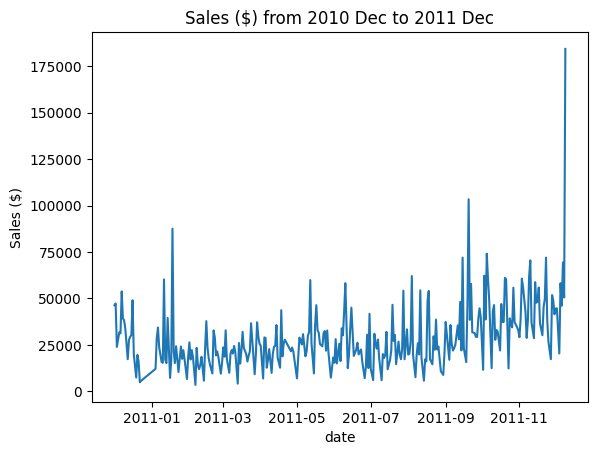

In [11]:
data['date'] = data.InvoiceDate.dt.date
data.groupby('date').TotalPrice.sum().plot()
plt.ylabel("Sales ($)")
plt.title("Sales ($) from 2010 Dec to 2011 Dec")
plt.show()

Interesting... There seems to be a very slight increase in sales from 2011 Jan to 2011 November, before spending booms upward in December. We can also see from the left side of the plot that the spending from 2010 Dec to 2011 Jan suffered a drop. This is probably due to year-end Christmas spending, which is expected.

# Feature Engineering

In marketing analysis, Recency, Frequency, and Marketing value (RFM) are features that can help us to segment the consumer base.

* Recency: When was the last time the customer bought a product?
* Frequency: How often does the customer purchase something?
* Marketing value: How much $ has the customer spent?

Source: https://www.techtarget.com/searchdatamanagement/definition/RFM-analysis


Let's calculate these values and add them to our dataframe!

In [12]:
rfm_metrics = data.groupby('CustomerID').agg(
    {
        'date' : lambda customer: data.date.max() - customer.max(),
        'InvoiceNo' : 'nunique',
        'TotalPrice' : 'sum'
    }
)

rfm_metrics.columns = ['recency', 'frequency', 'monetary_value']
rfm_metrics['recency'] = rfm_metrics.recency.dt.days
display(rfm_metrics)

,recency,frequency,monetary_value
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,277,1,180.60
18281.0,180,1,80.82
18282.0,7,2,178.05


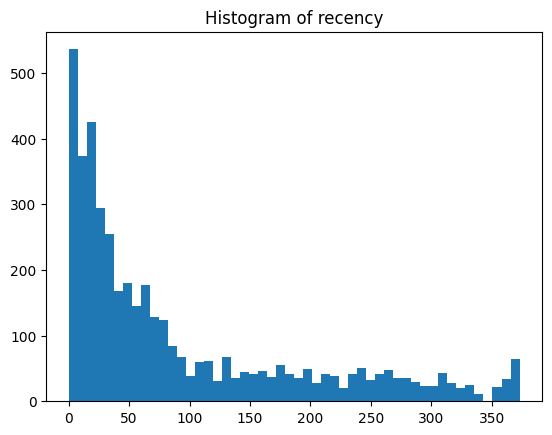

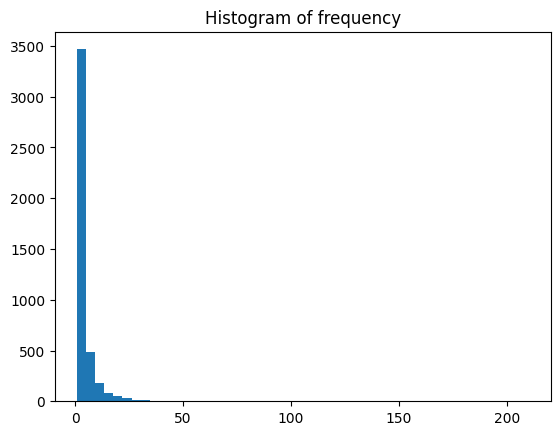

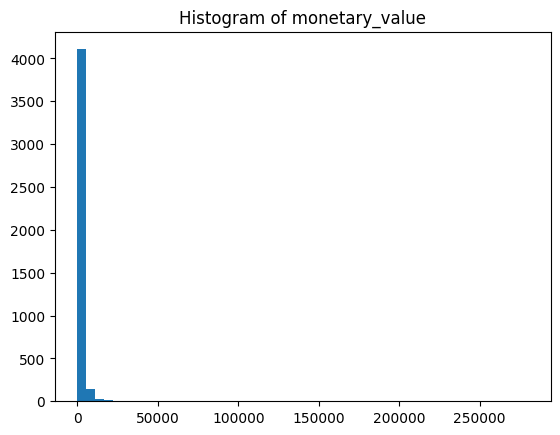

In [13]:
for feature in rfm_metrics.columns:
    plt.hist(rfm_metrics[feature], bins=50)
    plt.title(f'Histogram of {feature}')
    plt.show()

We'll simply use the RFM metrics to segment our consumer base for now. Let's move on to the modelling stage

In [14]:
rfm_metrics.to_csv(f"{REPO_PATH}/data/rfm_data.csv", index=False)
data.to_csv(f"{REPO_PATH}/data/online_retail_cleaned.csv", index=False)